# House grouping system
Queremos ser capaces de clasificar casas según su la región en la que se encuentren y del ingreso medio. Para ello, utilizaremos el famoso conjunto de datos California Housing. Se construyó utilizando los datos del censo de California de 1990. Contiene una fila por grupo de bloques censales. Un grupo de bloques es la unidad geográfica más pequeña para la que se publican datos del censo de USA.

In [2]:
#importamos librerias
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pickle import dump
from sklearn.metrics import silhouette_score

Cargamos el conjunto de datos 

In [3]:
# Empezamos cargando el conjunto de datos

housing_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv")

housing_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


En este caso solo nos interesan las columnas Latitude, Longitude y MedInc.

In [4]:
# Dropeamos las variables que no competen al analisis/modelo

housing_data = housing_data[["Latitude", "Longitude", "MedInc"]]
housing_data.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


Dividimos convenientemente el conjunto de datos en train y test

In [5]:
# Split en train y test


housing_data_train, housing_data__test = train_test_split(housing_data, test_size = 0.2, random_state = 42)
housing_data_train.head()

,Latitude,Longitude,MedInc
14196,32.71,-117.03,3.2596
8267,33.77,-118.16,3.8125
17445,34.66,-120.48,4.1563
14265,32.69,-117.11,1.9425
2271,36.78,-119.80,3.5542


Ahora usaremos algunos metodos para conocer el numero ideal de clusters
En principio, vamos a usar el metodo Elbow para determinar el numero de (k) centroides

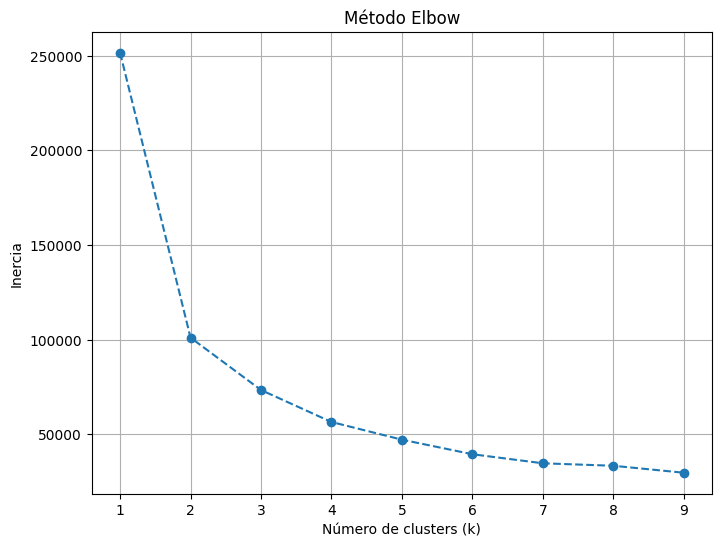

In [7]:
# En principio, vamos a usar el metodo Elbow para determinar el numero de (k) centroides

inertias = []

# se crea un forloop para probar diferentes valores de k
for k in range(1, 10):
    # modelo KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(housing_data)

    # Calcula la inercia y anade a la lista
    inertias.append(kmeans.inertia_)

# Graficamos el codo para visualizar el numero optimo de clusters
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertias, marker='o', linestyle='--')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método Elbow')
plt.grid(True)
plt.show()

Según el gráfico, deberiamos escoger entre 4 y 6 k o clusters

Ahora bien, para seguir analizando el n óptimo de clusters, vamos a utilizar el método silhouette

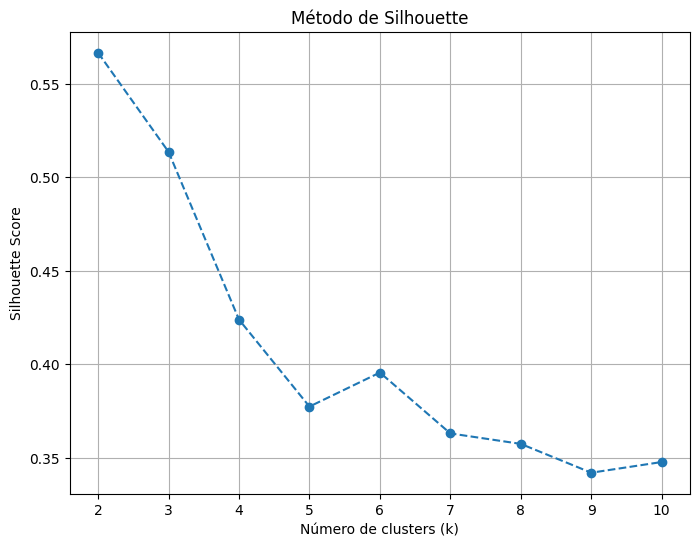

In [8]:
#creamos la función para calcular

def calculate_silhouette(data, max_k):
    silhouette_avg = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(housing_data)
        silhouette_avg.append(silhouette_score(housing_data, cluster_labels))
    return silhouette_avg

# Calculamos el puntaje de silueta para un rango de clusters
silhouette_avg = calculate_silhouette(housing_data, 10)

# Graficamos el puntaje de silueta
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_avg, marker='o', linestyle='--')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Método de Silhouette')
plt.grid(True)
plt.show()


Este método nos sugiere un número de 6 clusters.
Vamos a proceder con el entrenamiento Kmeans con 6 k

In [9]:
#Modelo Kmeans con 6 k

modelo_unsup = KMeans(n_clusters = 6, n_init = "auto", random_state = 42)
modelo_unsup.fit(housing_data_train)

KMeans(n_clusters=6, random_state=42)

In [10]:
y_train = list(modelo_unsup.labels_)
housing_data_train["Cluster"] = y_train
housing_data_train.head()

,Latitude,Longitude,MedInc,Cluster
14196,32.71,-117.03,3.2596,3
8267,33.77,-118.16,3.8125,1
17445,34.66,-120.48,4.1563,1
14265,32.69,-117.11,1.9425,3
2271,36.78,-119.80,3.5542,5


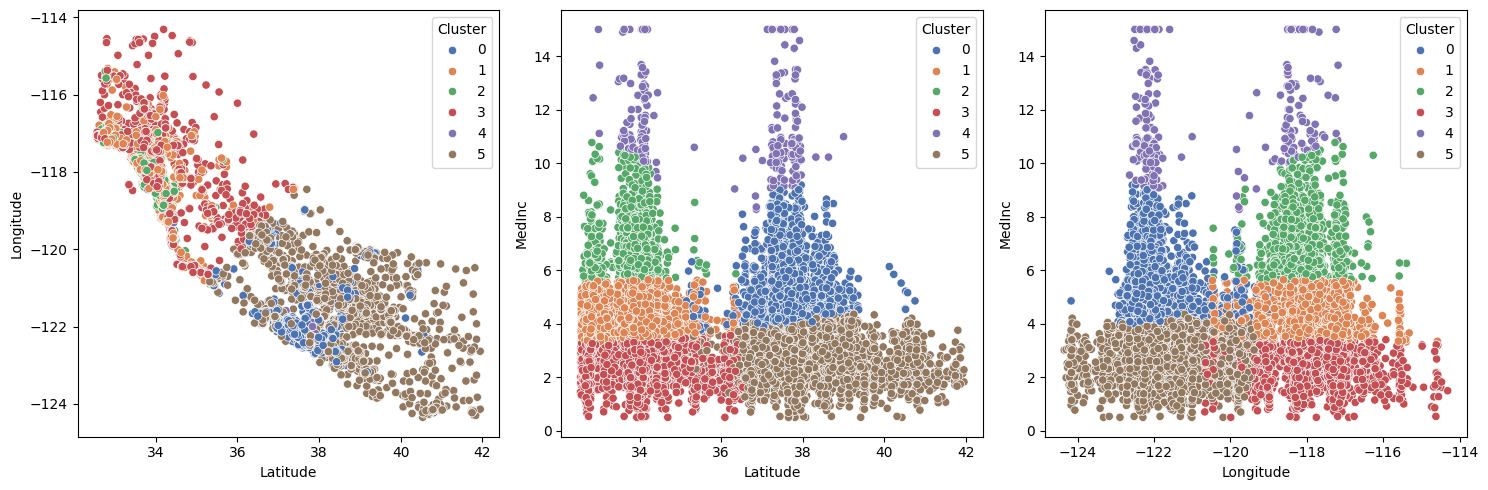

In [11]:
#VAmos a graficar los clusters
fig, axis = plt.subplots(1, 3, figsize = (15, 5))

sns.scatterplot(ax = axis[0], data = housing_data_train, x = "Latitude", y = "Longitude", hue = "Cluster", palette = "deep")
sns.scatterplot(ax = axis[1], data = housing_data_train, x = "Latitude", y = "MedInc", hue = "Cluster", palette = "deep")
sns.scatterplot(ax = axis[2], data = housing_data_train, x = "Longitude", y = "MedInc", hue = "Cluster", palette = "deep")
plt.tight_layout()

plt.show()
     

En el primer gráfico se hace dificil ver los clusters, pero en los de latitud y longitud vs medinc se aprecian bien los 6 clusters

Ahora que el K-Means nos ha devuelto una categorización (agrupación) de los puntos para los conjuntos de entrenamiento y prueba, estudiaremos qué modelo podría ser más útil y lo entrenamos. 

In [12]:
#Vamos a usar un Random Forest
modelo_superv = RandomForestClassifier(random_state = 42)
modelo_superv.fit(housing_data_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
#creamos ytest para la preddiccion

y_test = list(modelo_unsup.predict(housing_data__test))
housing_data__test["Cluster"] = y_test
housing_data__test.head()

,Latitude,Longitude,MedInc,Cluster
20046,36.06,-119.01,1.6812,3
3024,35.14,-119.46,2.5313,3
15663,37.80,-122.44,3.4801,5
20484,34.28,-118.72,5.7376,2
9814,36.62,-121.93,3.7250,5


In [14]:
#Predecimos
y_pred = modelo_superv.predict(housing_data__test)
y_pred

array([3, 3, 5, ..., 4, 5, 1], dtype=int32)

In [15]:
#Medimos el accuracy
accuracy_score(y_test, y_pred)

1.0

In [16]:
#guardamos el modelo
dump(modelo_unsup, open("../models/kmeans_k6.pkl", "wb"))